In [1]:
import cv2
import tqdm
import time
import torch
import string
import pathlib
import torchvision
import numpy as np
import pandas as pd
import segmentation_models_pytorch as smp

from sklearn.metrics import roc_auc_score, precision_score, recall_score, confusion_matrix, auc

from typing import List
from matplotlib import pyplot as plt

from predict import Prediction
from utils.dataset import Dataset
from utils.rgb import rgb2mask, mask2rgb, LABEL_COLORS
from utils.plots import plot_img_and_mask

# Logging
from utils.logging import logging

log = logging.getLogger(__name__)
log.setLevel(logging.INFO)

## Variables

In [2]:
patch_size = 768

## Util Functions

In [3]:
def create_mask_image(bbox_list, width, height):
    image = np.zeros((width, height, 1), np.uint8)
    for box in bbox_list:
        x, y, w, h = box
        cv2.rectangle(image, (x, y), (x + w, y + h), (255), -1)
    return image

def retrieve_bounding_boxes(input_image):
    count, hierarchy = cv2.findContours(input_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    bounding_boxes: List = []
    for contours in count:
        x, y, w, h = cv2.boundingRect(contours)
        if (w * h > 40):
            bounding_boxes.append([x, y, w, h])
    return bounding_boxes, len(bounding_boxes)

def preload_image_data(data_dir: string, img_dir: string, is_mask: bool = False):
    dataset_files: List = []
    with open(pathlib.Path(data_dir, 'test_dataset.txt'), mode='r', encoding='utf-8') as file:
        for i, line in enumerate(file):
            path = pathlib.Path(data_dir, img_dir, line.strip(), f'Image/{line.strip()}.png' if is_mask == False else f'Mask/0.png')

            # Load image
            img = cv2.imread(str(path))
            img = Dataset._resize_and_pad(img, (patch_size, patch_size), (0, 0, 0))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            if is_mask:
                img = rgb2mask(img)
            dataset_files.append(img)
    return dataset_files

test_imgs = preload_image_data(r'data', r'imgs', False)
test_labels = preload_image_data(r'data', r'imgs', True)
model_name = r'checkpoints/silvery-serenity-371/checkpoint.pth.tar'

In [4]:
def compute_IoU(cm):
    '''
    Adapted from:
        https://github.com/davidtvs/PyTorch-ENet/blob/master/metric/iou.py
        https://github.com/tensorflow/tensorflow/blob/v2.3.0/tensorflow/python/keras/metrics.py#L2716-L2844
    '''
    
    sum_over_row = cm.sum(axis=0)
    sum_over_col = cm.sum(axis=1)
    true_positives = np.diag(cm)

    # sum_over_row + sum_over_col = 2 * true_positives + false_positives + false_negatives.
    denominator = sum_over_row + sum_over_col - true_positives

    with np.errstate(divide='ignore', invalid='ignore'):
        iou = np.true_divide(true_positives, denominator)
        iou[iou == np.inf] = 0.0
        iou = np.nan_to_num(iou)
    return iou, np.nanmean(iou)

def IoU(mask_true, mask_pred, n_classes=2):
        labels = np.arange(n_classes)
        cm = confusion_matrix(mask_true.flatten(), mask_pred.flatten(), labels=labels)        
        return compute_IoU(cm)

## Model prediction

In [5]:
model_params = {
    'model_name': model_name,
    'patch_width': patch_size,
    'patch_height': patch_size,
    'n_channels': 3,
    'n_classes': 3
}
model = Prediction(model_params)
model.initialize()

log.info('[PREDICTION]: Model loaded!')
log.info(f'[PREDICTION]: Starting prediction on {len(test_imgs)} image(s).')

predicted_labels = []
img_process_time_list = []
m_ious = []

batch_start_time = time.time()
pbar = tqdm.tqdm(enumerate(test_imgs), total=len(test_imgs))
for i, img in pbar:
    img_start_time = time.time()
    mask_predict = model.predict_image(img)
    img_process_time = time.time() - img_start_time

    predicted_labels.append(mask_predict)
    img_process_time_list.append(img_process_time * 1000)

pbar.close()
batch_process_time = time.time() - batch_start_time

[PREDICTION]: Loading model checkpoints/silvery-serenity-371/checkpoint.pth.tar
[PREDICTION]: Model loaded!
[PREDICTION]: Starting prediction on 10 image(s).


100%|██████████| 10/10 [00:03<00:00,  2.90it/s]


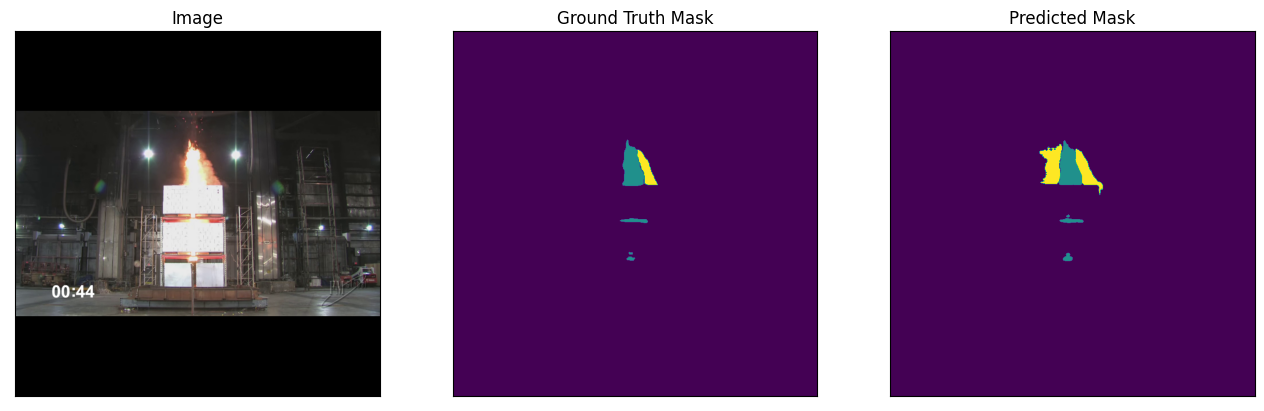

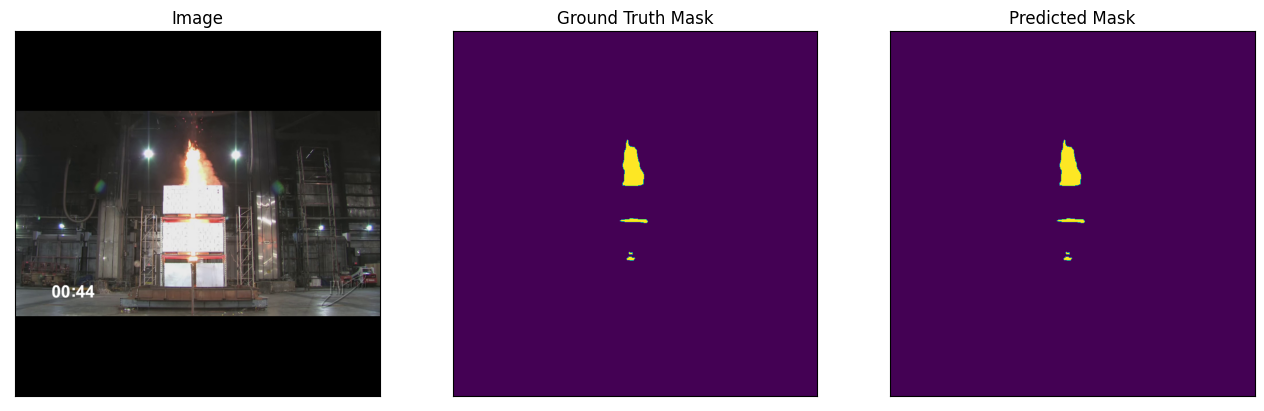

In [6]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

visualize(
    image=test_imgs[9], 
    ground_truth_mask=test_labels[9], 
    predicted_mask=predicted_labels[9]
)

# Extract fire
new_gt_mask = cv2.inRange(test_labels[9], 1, 1)
new_pt_mask = cv2.inRange(test_labels[9], 1, 1)

visualize(
    image=test_imgs[9], 
    ground_truth_mask=new_gt_mask, 
    predicted_mask=new_pt_mask
)

### Getting Metrics

In [7]:
def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):
  # Creating a set of all the unique classes using the actual class list
  unique_class = set(actual_class)
  roc_auc_list = [0.0, 0.0, 0.0]

  for per_class in unique_class:
    # Creating a list of all the classes except the current class 
    other_class = [x for x in unique_class if x != per_class]

    # Marking the current class as 1 and all other classes as 0
    new_actual_class = [0 if x in other_class else 1 for x in actual_class]
    new_pred_class = [0 if x in other_class else 1 for x in pred_class]

    # Using the sklearn metrics method to calculate the roc_auc_score
    try:
      roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
    except:
      roc_auc = 0.0    
    roc_auc_list[int(per_class)] = roc_auc

  return np.mean(roc_auc_list), roc_auc_list

100%|██████████| 10/10 [00:00<00:00, 163.56it/s]


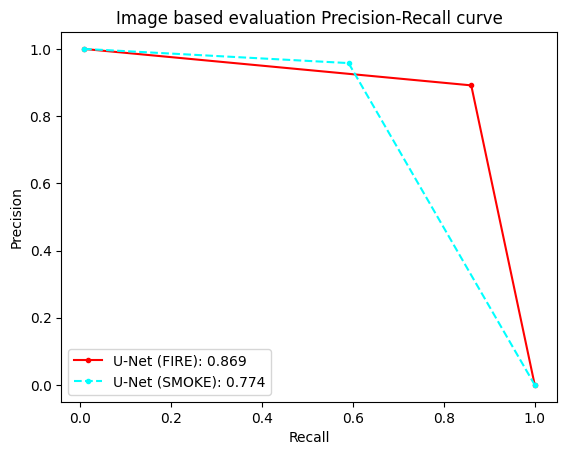

In [26]:
precision_list = []
recall_list = []
auc_list = []
iou_list = []

from sklearn.metrics import precision_recall_curve, auc

gt_list_fire = []
pred_list_fire = []

gt_list_smoke = []
pred_list_smoke = []

pbar = tqdm.tqdm(enumerate(test_labels), total=len(test_labels))
for i, label in pbar:
    # Fire
    ground_truth_fire = cv2.inRange(label, 1, 1)
    prediction_fire = cv2.inRange(predicted_labels[i], 1, 1)

    gt_mapped_fire = ground_truth_fire.flatten().astype('float') / 255
    pred_mapped_fire = prediction_fire.flatten().astype('float') / 255

    gt_list_fire.append(gt_mapped_fire)
    pred_list_fire.append(pred_mapped_fire)

    # Smoke
    ground_truth_smoke = cv2.inRange(label, 2, 2)
    prediction_smoke = cv2.inRange(predicted_labels[i], 2, 2)

    gt_mapped_smoke = ground_truth_smoke.flatten().astype('float') / 255
    pred_mapped_smoke = prediction_smoke.flatten().astype('float') / 255

    gt_list_smoke.append(gt_mapped_smoke)
    pred_list_smoke.append(pred_mapped_smoke)
pbar.close()

# Calculate Metrics
precision_fire, recall_fire, _ = precision_recall_curve(np.asarray(gt_list_fire).flatten(), np.asarray(pred_list_fire).flatten())
auc_fire = auc(precision_fire, recall_fire)

precision_smoke, recall_smoke, _ = precision_recall_curve(np.asarray(gt_list_smoke).flatten(), np.asarray(pred_list_smoke).flatten())
auc_smoke = auc(recall_smoke, precision_smoke)

# Plot Precision-Recall curve
plt.plot(precision_fire, recall_fire, marker='.', color='red', label=f'U-Net (FIRE): {round(auc_fire, 3)}')
plt.plot(precision_smoke, recall_smoke, marker='.', color='cyan', linestyle='--', label=f'U-Net (SMOKE): {round(auc_smoke, 3)}')

# axis labels
plt.title('Image based evaluation Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()
# plt.savefig("Image based evaluation Precision-Recall curve", format='svg', dpi=300)

# String log evaluation metrics
# log.info(
# f'Precision: {np.mean(precision_list):.5f} | \
# Recall: {np.mean(recall_list):.5f} | \
# AUC: {np.mean(auc_list):.5f} | \
# Processing Time: {batch_process_time * 1000}s'
# )

C:\Users\matej\AppData\Local\Temp\ipykernel_13816\1117178798.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:233.)
  target = torch.tensor(target)


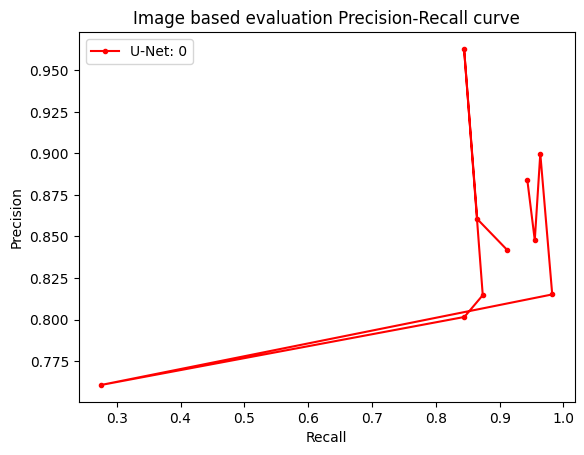

In [9]:
target = test_labels
output = predicted_labels

target = torch.tensor(target)
output = torch.tensor(output)

target = target.long()

tp, fp, fn, tn = smp.metrics.get_stats(output, target, mode='multiclass', num_classes=model_params['n_classes'])

recall_list = smp.metrics.recall(tp, fp, fn, tn)
precision_list = smp.metrics.precision(tp, fp, fn, tn)

auc_s = 0 #, auc_per_class = roc_auc_score_multiclass(ground_truth_fire, prediction_fire)
# iou_score = smp.metrics.iou_score(tp, fp, fn, tn, "micro")

plt.plot(recall_list[:,1], precision_list[:,1], marker='.', color='red', label=f'U-Net: {round(auc_s, 3)}')

# axis labels
plt.title('Image based evaluation Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()
# plt.savefig("Image based evaluation Precision-Recall curve", format='svg', dpi=300)

### Visualization of prediction data

c:\Posao\firebot-segmentation\.env\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Posao\firebot-segmentation\.env\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


FileNotFoundError: [Errno 2] No such file or directory: 'results/img_based_eval_precision_recall_curve.svg'

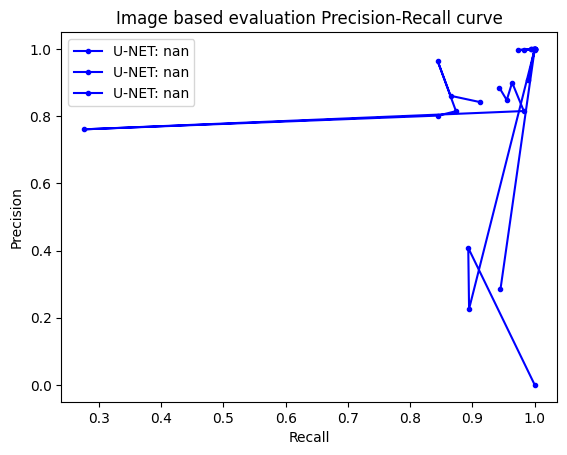

In [10]:
# Image Based eval Precision-Recall curve
recall_list.sort()
precision_list.sort()

plt.plot(recall_list, precision_list, marker='.', color='blue', label=f'U-NET: {np.mean(auc_list):.2f}')
plt.title('Image based evaluation Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.savefig('results/img_based_eval_precision_recall_curve.svg', format='svg', dpi=300)

### Saving data to Excel

In [ ]:
import pandas as pd


metrics_frame = pd.DataFrame()
iou_frame = pd.DataFrame()

### Za Franka

In [ ]:
import PIL
import matplotlib.image as mpimg

franko_dir = pathlib.Path(r'franko')
images_dir = pathlib.Path(franko_dir, r'images')
ground_truth_dir = pathlib.Path(franko_dir, r'ground_truths')
predictions_dir = pathlib.Path(franko_dir, r'predictions')

for i, img in tqdm.tqdm(enumerate(test_imgs), total=len(test_imgs)):
    save_img = PIL.Image.fromarray(img)
    save_img.save(str(pathlib.Path(images_dir, f'{i}.png')))

for i, ground_truth in tqdm.tqdm(enumerate(test_labels), total=len(test_labels)):
    mpimg.imsave(str(pathlib.Path(ground_truth_dir, f'{i}.png')), ground_truth, cmap='gray')

for i, predicted_img in tqdm.tqdm(enumerate(predicted_labels), total=len(predicted_labels)):
    mpimg.imsave(str(pathlib.Path(predictions_dir, f'{i}.png')), predicted_img, cmap='gray')